# Experiments

## Provided Code



In [0]:
from random import randint, choice, seed
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from math import pow
from math import factorial
from math import log 
from time      import time
import matplotlib.pyplot as plt
import copy
from google.colab import files

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n, points=None, max_d=MAX_DISTANCE):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]

    if not points: #so we can pass it our own points as well
        points = []
        for p in range(n):
            start = True
            while start or (x,y) in points:
                start=False
                x, y = randint(0, max_d), randint(0, max_d)
            points.append((x,y))
    for i in range(len(points)):
        p1 = points[i]
        for j in range(i+1,len(points)):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return points, dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c
    
def greedy_nearest_neighbours(G, endpoints=None):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return cycle

def exhaustive_search(G, endpoints=None):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n-1]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return best_cycle

## Extra Utility Functions

In [0]:
def plotPoints(points, paths=True):
    plt.scatter(*zip(*points))
    if paths:
        for i in range(len(points)):
            for j in range(i, len(points)):
                plt.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]])
    plt.show()

def plotSolution(solution, points):
    finalPoints = []
    for city in solution:
        for point in range(len(points)):
            if city==point:
                finalPoints.append(points[point])
    plt.scatter(*zip(*finalPoints))
    for i in range(len(points) -1):
        plt.plot([finalPoints[i][0], finalPoints[i+1][0]], [finalPoints[i][1], finalPoints[i+1][1]])
    plt.show()

def get_percentage_delta(graphList, allCosts1, allCosts2):
    costTotal1 = 0
    costTotal2 = 0 
    percentageDelta = []
    currentSize = 2 #always start at length 2

    for cost1, cost2, graph in zip(allCosts1, allCosts2, graphList):
        if len(graph) == currentSize: #so we average the same size graphs
            costTotal1 += cost1
            costTotal2 += cost2
        else:
            percentageDelta.append(costTotal1 / costTotal2 * 100)
            costTotal1 = 0
            costTotal2 = 0 
            currentSize = len(graph) #advance onto the next size

    if costTotal1 != 0 or costTotal2 != 0:
        percentageDelta.append(costTotal1 / costTotal2 * 100)

    return percentageDelta

def get_solutions_costs_times(tsp_function, graphList, maxTime=oo):
    allSolutions= []
    allCosts = []
    allTimes = []
    for graph in graphList: #looping over graphs
        start = time()
        pathAlgorithm = tsp_function(graph)
        totalTime = time() - start
        allSolutions.append(pathAlgorithm)
        allCosts.append(cost(graph, pathAlgorithm))
        allTimes.append(totalTime)
        print("GNN/EXH --> %d : %f" % (len(graph), totalTime))
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def get_solutions_grasp(tsp_function, graphList, maxTime=oo):
    allSolutions= []
    allCosts = []
    allTimes = []
    for graph in graphList: #looping over graphs
        city_tour=seed_function(graph)
        start = time()
        pathAlgorithm = tsp_function(graph, city_tour=city_tour, iterations = 20, rcl = 5, greediness_value = 0.5)
        totalTime = time() - start
        pathAlgorithm[0] = [x - 1 for x in pathAlgorithm[0]]
        allSolutions.append(pathAlgorithm[0])
        allCosts.append(cost(graph, pathAlgorithm[0]))
        allTimes.append(totalTime)
        print("GRASP --> %d : %f" % (len(graph), totalTime))
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def euclidean(a, b):
    return ((a[1] - b[1])**2 + (a[0] - b[0])**2)**0.5

def get_aco_solutions_costs_times(pointList, graphList, maxTime=oo):
    allSolutions= []
    allCosts = []
    allTimes = []
    for points, graph in zip(pointsList, graphList):
        world = pants.World(points, euclidean)
        solver = pants.Solver()

        start = time()
        solution = solver.solve(world)
        totalTime = time()-start

        finalSolution = []
        for city in solution.tour:
            finalSolution.append(points.index(city))

        allSolutions.append(finalSolution)
        allTimes.append(totalTime)
        allCosts.append(cost(graph, finalSolution))
        print("ACO --> %d : %f" % (len(points), totalTime))
        if maxTime < totalTime:
            break

    return allSolutions, allCosts, allTimes

def filter_costs_times(solutions, costs, times):
    filteredTimes = []
    filteredCosts = []
    timeTotal = 0
    costTotal = 0
    averageCounter = 0
    currentSize = len(solutions[0]) #always start at length 2
    for solution, cost, time in zip(solutions, costs, times):
        if len(solution) == currentSize: #so we average the same size graphs
            timeTotal += time
            costTotal += cost
            averageCounter += 1
        else:
            filteredTimes.append(timeTotal / averageCounter)
            filteredCosts.append(costTotal / averageCounter)
            timeTotal = 0
            costTotal = 0
            averageCounter = 0
            currentSize = len(solution) #advance onto the next size
    if averageCounter != 0:
        filteredTimes.append(timeTotal / averageCounter)
        filteredCosts.append(costTotal / averageCounter)
    return filteredCosts, filteredTimes

### GRASP Algorithm, ref: https://github.com/Valdecy/Metaheuristic-Local_Search-GRASP

In [0]:
!git clone https://github.com/sergiuharjau/Metaheuristic-Local_Search-GRASP
import sys
sys.path.insert(1, 'Metaheuristic-Local_Search-GRASP')
from grasp import *

### ACO Algorithm, ref: https://pypi.org/project/ACO-Pants/

In [0]:
!pip3 install ACO-Pants
import pants

### PyConcorde Algorithm, ref: https://github.com/jvkersch/pyconcorde

In [0]:
# Processing happens on a local machine, therefore no imports in notebook

## Create Dataset

In [0]:
max_size = 30
graphList = []; pointsList = []
for i in range(2, max_size): # Create 200 graphs of sizes [2,max_size]
    for j in range(2): # do it 10 times each
        points, graph = random_euclidean_graph(i)
        graphList.append(graph)
        pointsList.append(points)

## Correct format for GRASP algorithm

In [0]:
#Create Correct Format NP Array Matrix
import numpy as np

npGraphList=[]
for points in pointsList:
    correctFormat = []
    for tuple in points:
        correctFormat.append(np.array(tuple))
    correctFormat = np.array(correctFormat)
    npGraphList.append(buid_distance_matrix(correctFormat))

## Send data for PyConcorde Computation

In [12]:
# Exporting PointsList to file for Concorde Processing
file1= open("points_concorde.txt", "w")
for point in pointsList:
    outputStream = "["
    for element in point:
        outputStream += str(element) + ", "
    file1.write(outputStream[:-2] + "]\n")
files.download("points_concorde.txt")
print("Ensure line count of file is: ", len(pointsList))

Ensure line count of file is:  56


## Receive PyConcorde Results

In [0]:
# Importing Solutions and Time from Concorde output files
!rm output*
concorde_file_solutions = files.upload() #Solutions only work from index 50 onwards
concorde_file_times = files.upload() #Only from 50 onwards

# Parsing files into standardised format
pyc_sols=[]
for line in concorde_file_solutions["output_solutions.txt"].decode().split("\n")[:-1]:
    tempSol=[]
    for element in line[1:-1].split(","):
        tempSol.append(int(element))
    pyc_sols.append(tempSol)

pyc_times=[]
for line in concorde_file_times["output_time.txt"].decode().split("\n")[:-1]:
    pyc_times.append(float(line))

pyc_costs=[]
for solution, graph in zip(pyc_sols, graphList):
    pyc_costs.append(cost(graph, solution))

## Computing GRASP, GreedyNN, Exhaustive, ACO

In [0]:
# Solve all other algorithms
sol4, cost4, time4 = get_aco_solutions_costs_times(pointsList, graphList, maxTime=8)
sol1, cost1, time1 = get_solutions_grasp(greedy_randomized_adaptive_search_procedure, npGraphList, maxTime=8)
sol2, cost2, time2 = get_solutions_costs_times(greedy_nearest_neighbours, graphList)
sol3, cost3, time3 = get_solutions_costs_times(exhaustive_search, graphList, maxTime=8)

In [0]:
# Average results
filter_cost_tsp, filter_time_tsp = filter_costs_times(sol1, cost1, time1)
filter_cost_gnn, filter_time_gnn = filter_costs_times(sol2, cost2, time2)
filter_cost_pyc, filter_time_pyc = filter_costs_times(pyc_sols, pyc_costs, pyc_times)
filter_cost_exh, filter_time_exh = filter_costs_times(sol3, cost3, time3)
filter_cost_aco, filter_time_aco = filter_costs_times(sol4, cost4, time4)

## Showing different solutions on same graph

All possible paths.


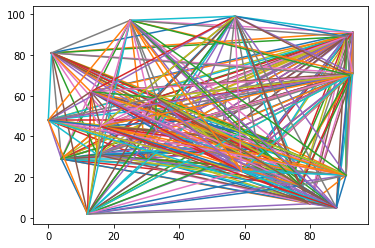

Cost of GreedyNN solution:  629


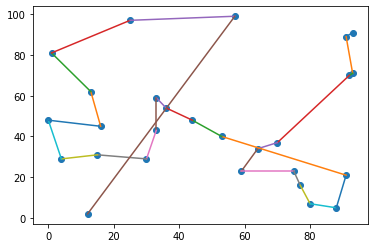

Cost of GRASP solution:  464.0


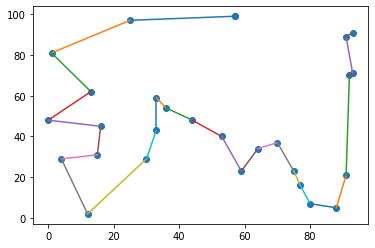

Cost of ACO solution:  541


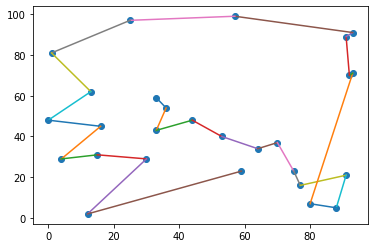

Cost of PyConcorde solution:  464


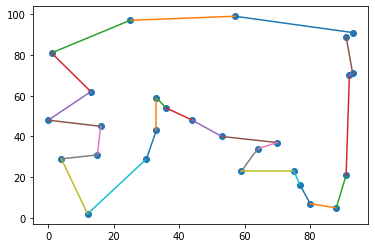

In [0]:
n = 250 #Position you want to see solution at

print("All possible paths.")
plotPoints(pointsList[n])
print("Cost of GreedyNN solution: ", round(cost2[n]))
plotSolution(sol2[n], pointsList[n])
print("Cost of GRASP solution: ", round(cost1[n]))
plotSolution(sol1[n], pointsList[n])
print("Cost of ACO solution: ", round(cost4[n]))
plotSolution(sol4[n], pointsList[n])
print("Cost of PyConcorde solution: ", round(pyc_costs[n]))
plotSolution(pyc_sols[n], pointsList[n])

### Discussion

For 200 cities, an exhaustive search (with O-notation: O(n!)) can produce a correct answer in time complexity: O(200!).

Pyconcorde refers to a python implementation of the concorde TSP solution which “is widely regarded as the fastest TSP solver, for large instances, currently in existence.” (Mulder and Wunsch, 2003) and is used to this day for mapping genes, bitmap conversion for images and calculating shortest path algorithms. Therefore, it is not surprising that when comparing this method to GreedyNN and ACO for 200 cities, this solution does produce a better route at 464 total unit distance for the path.

The GRASP solution resulted also in 464 while ACO produced a result of 541, making GRASP’s solution better than ACO in this iteration for 250 cities.


# Cost Analysis up to 50 cities

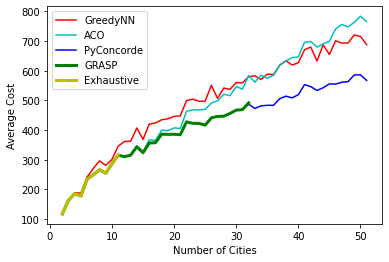

In [0]:
plt.plot(range(2, 52) , filter_cost_gnn[:50], 'r', label="GreedyNN")
plt.plot(range(2, 52) , filter_cost_aco[:50], 'c', label="ACO")
plt.plot(range(2, 52) , filter_cost_pyc[:50], 'b', label="PyConcorde")
plt.plot(range(2, len(filter_cost_tsp)+2) , filter_cost_tsp, 'g', label="GRASP", linewidth=3)
plt.plot(range(2, len(filter_cost_exh)+2) , filter_cost_exh, 'y', label="Exhaustive", linewidth=3)

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

### Discussion

The cost of ACO for a lesser number of cities is just as ideal as the concorde implementation up until 16 cities, where the average cost for any city above is larger than concorde and grasp. As the number of cities continues to increase, the average cost for ACO exceeds GreedyNN  also implying ACO is not a suitable metaheuristic solution for much larger node sizes. The exhaustive search was a viable solution until 11 cities, at this point the line for exhaustive stops due to taking too long to compute (see time analysis below). Similarly, the cost analysis for GRASP also only goes up to a point before stopping due to the time constraints. Up until 32 cities, the average cost is the same as the concorde implementation making it more cost efficient than ACO.

 The best algorithm for cost efficiency is unsurprisingly, PyConcorde followed by GRASP and then ACO until the city number reaches 36 and finally; GreedyNN (until 36). Exhaustive search, while it is feasible to carry out this algorithm, was just as cost effective a GRASP and concorde and more cost effective than ACO. This is because of the computer resources required to run an exhaustive search is cheap when compared to, for example ACO where pheromone evaporation / deposit, distance and calculations on the probability of a path being taken must all be calculated. ACO as a heuristic algorithm having “many shortcomings, such as low searching efficiency” (Gao, 2020). (Lourenc¸o et al. (2002)) says in his paper that the main diﬀerence between ACO and GRASP is the pheromone-based memory which lacks in GRASP.

(Skinderowicz, 2016) researched in his paper ways of improving the computation time of an ant-colony optimization algorithm. One such method he applied is called a restart procedure which “consists in restarting the MOA after a certain criterion is met”, an example of such for ACO would be restarting the algorithm after a certain number of iterations, or resetting he pheromone which is what was done in this paper. The reasoning for this restart is so that various, (maybe) different solutions can be collected and the highest quality one becomes the final solution to the problem. The final results showed that “conducted on a set of TSP and Quadratic Assignment instances showed that the pheromone resetting signiﬁcantly improved results of the algorithm”.


# Time Analysis up to 50 cities

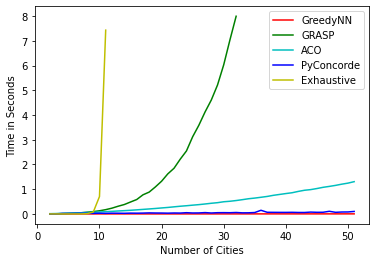

In [0]:
plt.plot(range(2, 52) , filter_time_gnn[:50], 'r', label="GreedyNN")
plt.plot(range(2, len(filter_time_tsp)+2) , filter_time_tsp, 'g', label="GRASP")
plt.plot(range(2, 52) , filter_time_aco[:50], 'c', label="ACO")
plt.plot(range(2, 52) , filter_time_pyc[:50], 'b', label="PyConcorde")
plt.plot(range(2, len(filter_time_exh)+2) , filter_time_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()

### Discussion

The trend for time however, shows exhaustive having a sharp rise after 10 cities are introduced (nearing one second to calculate the route) and an even sharper one for 12 (exceeding 7 seconds, the y-axis limit for the graph). This is due to exhaustive searches factorial time complexity. The graph also explains why the GRASP cost analysis stopped at 32 cities as the time it took for the GRASP implementation to calculate a solution exceeds the 8 second limit we set. GRASP showed a sharp rise in time complexity, especially when compared to ACO which was able to find a solution relatively quickly, taking only 1.2 seconds to calculate a solution for 50 cities. Unsurprisingly, the business standard TSP algorithm; concorde was able to calculate a solution in less than 0.2 seconds consistently.

The advantage of GRASP compared to any other heuristic method lies in its simplicity (and therefore making it a rather fast method). GRASP consists of a two-part method, with the first phase consists of constructing and the second consisting of improving. To improve GRASP, one can implement some sort of learning and memory or path-relinking (Fleurent and Glover (1999)).



# Quality Analysis up to 500 cities

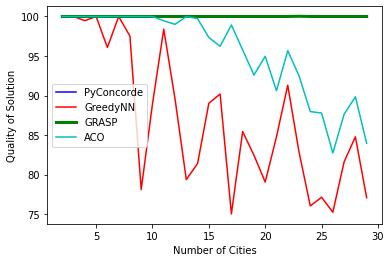

In [16]:
tsp_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost1)
gnn_vs_pyc = get_percentage_delta(graphList, pyc_costs, cost2)
aco_vs_pyc = get_percentage_delta(graphList, pyc_costs[:len(cost4)], cost4)

plt.plot(range(2, max_size), [100]*(max_size-2), "b", label="PyConcorde")
plt.plot(range(2, len(gnn_vs_pyc)+2), gnn_vs_pyc,  'r', label="GreedyNN")
plt.plot(range(2, len(tsp_vs_pyc)+2), tsp_vs_pyc,  'g', label="GRASP", linewidth=3)
plt.plot(range(2, len(aco_vs_pyc)+2), aco_vs_pyc,  "c", label="ACO")

plt.xlabel("Number of Cities")
plt.ylabel("Quality of Solution")
plt.legend()
plt.show()

### Discussion

When compared to the PyConcorde solution, the quality of ACO and the GRASP implementation can be plotted against increasing the number of cities. Again, GRASP can be seen as optimal a solution as concorde until 32 cities, when the time complexity reduces its worth. Meanwhile,  the quality of the ACO solution shows a sharp decreasing trend past 12 cities, reducing down to 60% relative effectiveness for 125 cities. ACO is a better metaheuristic algorithm quality-wise than the GreedyNN implementation until 36 cities. GreedyNN has a sharp decrease in quality as soon as the number of cities begin increasing, however level out at 80% effectiveness for increasing city sizes making it the best solution (other than concorde) for larger city sizes.

# Cost Analysis up to 500 cities

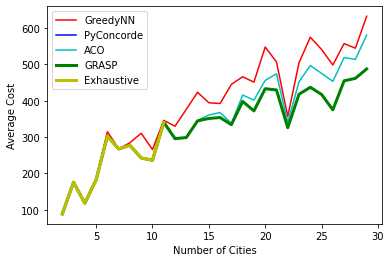

In [22]:
plt.plot(range(2, len(filter_cost_gnn)+2) , filter_cost_gnn, 'r', label="GreedyNN")
plt.plot(range(2, len(filter_cost_pyc)+2) , filter_cost_pyc, 'b', label="PyConcorde")
plt.plot(range(2, len(filter_cost_aco)+2) , filter_cost_aco, 'c', label="ACO")
plt.plot(range(2, len(filter_cost_tsp)+2) , filter_cost_tsp, 'g', label="GRASP", linewidth=3)
plt.plot(range(2, len(filter_cost_exh)+2) , filter_cost_exh, 'y', label="Exhaustive", linewidth=3)



plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

### Discussion

As we extend the number of cities to 150, we can clearly see the trend each metaheuristic takes for cost. Once the city limit surpasses 120, the average cost of the ACO implementation begins to exceed past the y-axis of the graph highlighting that ACO is not a suitable metaheuristic algorithm for large node sizes. 

# Time Analysis up to 500 cities

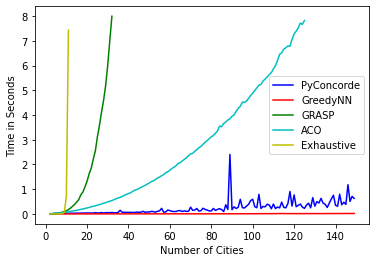

In [0]:
plt.plot(range(2, len(filter_time_pyc)+2) , filter_time_pyc, 'b', label="PyConcorde")
plt.plot(range(2, len(filter_time_gnn)+2) , filter_time_gnn, 'r', label="GreedyNN")
plt.plot(range(2, len(filter_time_tsp)+2) , filter_time_tsp, 'g', label="GRASP")
plt.plot(range(2, len(filter_time_aco)+2) , filter_time_aco, 'c', label="ACO")
plt.plot(range(2, len(filter_time_exh)+2) , filter_time_exh, 'y', label="Exhaustive")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()

### Discussion

The same is shown for the time graph: once surpassing 120, ACO takes an unfeasible amount of time.

# Time Growth Analysis


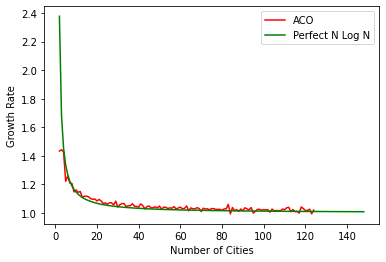

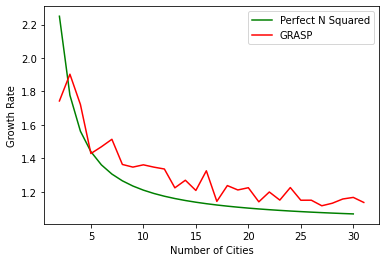

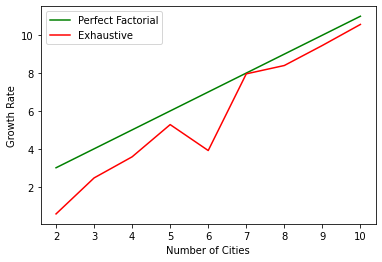

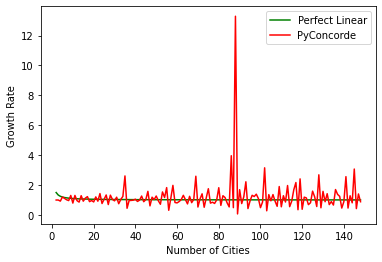

In [0]:
def get_growth(time_list):
    growth=[]
    for i in range(len(time_list)):
        if time_list[i] == 0:
            growth.append(1)
            continue
        if i < len(time_list) - 1:
            growth.append(time_list[i+1]/time_list[i])
    return growth

perfectLogN = [n*log(n) for n in range(2, len(filter_time_gnn)+2)]
plt.plot(range(2, len(filter_time_aco)+1) , get_growth(filter_time_aco), 'r', label="ACO") 
plt.plot(range(2, len(filter_time_gnn)+1) , get_growth(perfectLogN), 'g', label="Perfect N Log N") 
plt.xlabel("Number of Cities")
plt.ylabel("Growth Rate")
plt.legend()
plt.show()

perfectSquared=[n**2 for n in range(2, len(filter_time_tsp) +1)]
plt.plot(range(2, len(filter_time_tsp)) , get_growth(perfectSquared), 'g', label="Perfect N Squared") 
plt.plot(range(2, len(filter_time_tsp)+1) , get_growth(filter_time_tsp), 'r', label="GRASP") 
plt.xlabel("Number of Cities")
plt.ylabel("Growth Rate")
plt.legend()
plt.show()

perfectFactorial = [factorial(n) for n in range(2, len(filter_time_exh) +2)]
plt.plot(range(2, len(filter_time_exh)+1) , get_growth(perfectFactorial), 'g', label="Perfect Factorial") 
plt.plot(range(2, len(filter_time_exh)+1) , get_growth(filter_time_exh), 'r', label="Exhaustive") 
plt.xlabel("Number of Cities")
plt.ylabel("Growth Rate")
plt.legend()
plt.show()

perfectLinear = [n for n in range(2, len(filter_time_pyc) +2)]
plt.plot(range(2, len(filter_time_pyc)+1) , get_growth(perfectLinear), 'g', label="Perfect Linear") 
plt.plot(range(2, len(filter_time_pyc)+1) , get_growth(filter_time_pyc), 'r', label="PyConcorde")
plt.xlabel("Number of Cities")
plt.ylabel("Growth Rate") 
plt.legend()
plt.show()

### Discussion

When plotting growth rate against the number of cities:

ACO shows a perfect N Log N trend

GRASP shows an n^2 trend

Exhaustive shows a factorial trend

Concorde shows a linear trend


# Analysis based on city density: PyConcorde vs GreedyOptimization

## Simple Greedy Optimised Algorithm, ref: https://github.com/dmishin/tsp-solver

In [0]:
!pip3 install tsp_solver2
from tsp_solver.greedy import solve_tsp

## Create Dataset
### 10 graph average--> sizes [10, 15, 20...395, 400] on 20x20 grid

In [0]:
graphList = []; pointsList = []
for i in range(10, 401)[::5]:
    for j in range(10): # do it 10 times each
        points, graph = random_euclidean_graph(i, max_d=19)
        graphList.append(graph)
        pointsList.append(points)

## Density Example

		50 cities, density: 0.125


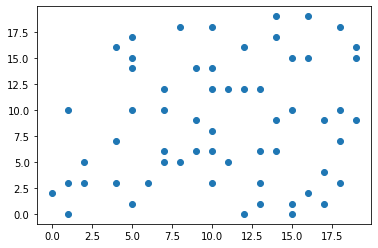

		200 cities, density: 0.5


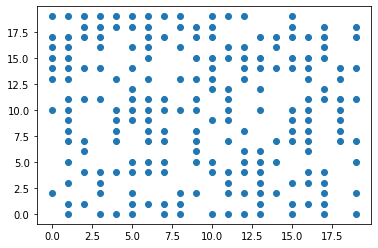

		400 cities, density: 1


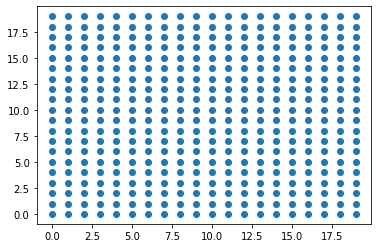

In [38]:
print("\t\t50 cities, density: 0.125")
plotPoints(pointsList[ 50*2], paths=False)
print("\t\t200 cities, density: 0.5")
plotPoints(pointsList[200*2], paths=False)
print("\t\t400 cities, density: 1")
plotPoints(pointsList[-1], paths=False)

## Solving in both GreedyOPT and PyConcorde

In [0]:
# Exporting PointsList to file for Concorde Processing
file1= open("density_points.txt", "w")
for point in pointsList:
    outputStream = "["
    for element in point:
        outputStream += str(element) + ", "
    file1.write(outputStream[:-2] + "]\n")
files.download("density_points.txt")

In [0]:
# Importing Solutions and Time from Concorde output files
!rm density*.txt
concorde_file_solutions = files.upload() #Solutions only work from index 50 onwards
concorde_file_times = files.upload() #Only from 50 onwards

# Parsing files into standardised format
pyc_sols=[]
for line in concorde_file_solutions["density_output_solutions.txt"].decode().split("\n")[:-1]:
    tempSol=[]
    for element in line[1:-1].split(","):
        tempSol.append(int(element))
    pyc_sols.append(tempSol)

pyc_times=[]
for line in concorde_file_times["density_output_time.txt"].decode().split("\n")[:-1]:
    pyc_times.append(float(line))

pyc_costs=[]
for solution, graph in zip(pyc_sols, graphList):
    pyc_costs.append(cost(graph, solution))

filter_cost_pyc, filter_time_pyc = filter_costs_times(pyc_sols, pyc_costs, pyc_times)

In [0]:
sol1, cost1, time1 = get_solutions_costs_times(solve_tsp, graphList)
filter_cost_tsp, filter_time_tsp = filter_costs_times(sol1, cost1, time1)

## Example of solution where GreedyOPT outperforms PyConcorde 
### Density=0.72, Cities=287/400

All cities.


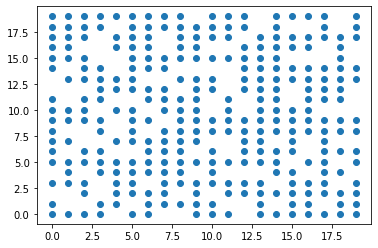

Cost of GreedyOPT solution:  349


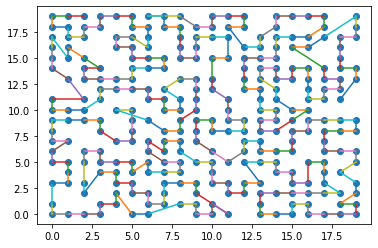

Cost of PyConcorde solution:  352


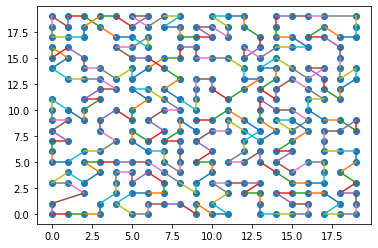

In [57]:
n = 287*2

print("All cities.")
plotPoints(pointsList[n], paths=False)
print("Cost of GreedyOPT solution: ", round(cost1[n]))
plotSolution(sol1[n], pointsList[n])
print("Cost of PyConcorde solution: ", round(pyc_costs[n]))
plotSolution(pyc_sols[n], pointsList[n])

# Cost: TSP-Solver vs PyConcorde

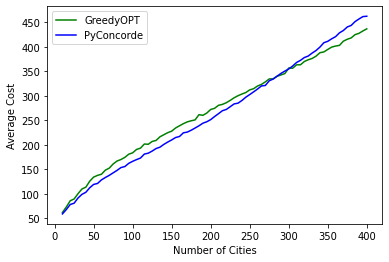

In [52]:
plt.plot(range(10,401)[::5], filter_cost_tsp, 'g', label="GreedyOPT")
plt.plot(range(10,401)[::5], filter_cost_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Average Cost")
plt.legend()
plt.show()

# Time: TSP-Solver vs PyConcorde

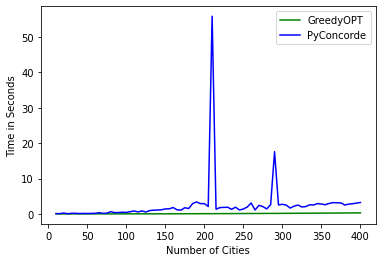

In [54]:
plt.plot(range(10,401)[::5], filter_time_tsp, 'g', label="GreedyOPT")
plt.plot(range(10,401)[::5], filter_time_pyc, 'b', label="PyConcorde")

plt.xlabel("Number of Cities")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()

### Discussion

A solution in which a simple GreedyOPT algorithm outperforms Concorde is when we set the city density to be 0.72, which equates to 288 nodes out of a possible 400. With these parameters, the GreedyOPT implementation using TSP-Solver was able to find a path with a total distance of 342 while the concorde solution equalling 352. GreedyOPT can outperform Concorde on a number of different occasions. The average cost graph plotting concorde and GRASP against an increasing number of cities up to 400, shows GreedyOPT actually costing on average less than concorde once the number of cities exceeds 305, implying GreedyOPT is actually a better solution for a much larger city count. This is especially shown when displaying the time graph for 400 cities. Again, both algorithms show a general trend of increasing time as the number of cities increase, but the GRASP solution only grows slight and steadily in time. At 400 cities, GreedyOPT took 0.4 seconds to produce an answer, while concorde took 2.4 seconds.

# References:

Fleurent, C. and F. Glover (1999). “Improved constructive multistart strategies for the quadratic assignment problem using adaptive memory”. In: INFORMS Journal on Computing 11.2, pp. 198–204.

Gao, W., 2020. New Ant Colony Optimization Algorithm for the Traveling Salesman Problem. International Journal of Computational Intelligence Systems, 13(1), pp.44-55.

Lourenc¸o, H. R., O. C. Martin, and T. Stu¨tzle (2002). “Iterated local search”. In: Handbook of Metaheuristics, volume 57 of International Series in Operations Research and Management Science. Ed. by F. Glover and G. 

Kochenberger. Kluwer Academic Publishers, pp. 321–353.

Mulder, S. and Wunsch, D., 2003. Million city traveling salesman problem solution by divide and conquer clustering with adaptive resonance neural networks. 

Neural Networks, 16(5-6), pp.827-832. 
Skinderowicz, R., 2016. Ant Colony System With A Restart Procedure For TSP. pp.91-101.
